In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.datasets import fetch_20newsgroups

categories1 = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.ibm.pc.hardware' ]
categories2 = [ 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
train1 = fetch_20newsgroups(subset='train', categories=categories1, shuffle=True, random_state=42, remove=('headers', 'footers'))
test1 = fetch_20newsgroups(subset='test', categories=categories1, shuffle=True, random_state=42, remove=('headers', 'footers'))
train2 = fetch_20newsgroups(subset='train', categories=categories2, shuffle=True, random_state=42, remove=('headers', 'footers'))
test2 = fetch_20newsgroups(subset='test', categories=categories2, shuffle=True, random_state=42, remove=('headers', 'footers'))


In [47]:
print(train1.target_names)
print(train2.target_names)
print(train1.target)
print(train2.target)

['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.ibm.pc.hardware']
['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
[2 1 2 ... 1 2 2]
[0 3 0 ... 3 1 2]


In [48]:
X_train1_data = train1.data 
X_train2_data = train2.data
y_train1 = list(train1.target)
y_train2 = list(train2.target)
# y_train = [0]*len(list(train1.target)) + [1]*len(list(train2.target))
# print(y_train)

In [49]:
count_vect = CountVectorizer(stop_words='english', min_df=3, max_df=0.7)
X_train1_counts = count_vect.fit_transform(X_train1_data)
X_train1_counts.shape

(1765, 8597)

In [50]:
X_train2_counts = count_vect.fit_transform(X_train2_data)
X_train2_counts.shape

(2389, 10361)

In [51]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

X_train1_tfidf = tfidf_transformer.fit_transform(X_train1_counts)
print(X_train1_tfidf.shape)

(1765, 8597)


In [52]:
X_train2_tfidf = tfidf_transformer.fit_transform(X_train2_counts)
print(X_train2_tfidf.shape)

(2389, 10361)


Clustering sparse data with KMeans(max_iter=2000, n_clusters=2, n_init=100)
done in 1.880s

Homogeneity: 0.095
Completeness: 0.307
V-measure: 0.145
Adjusted Rand-Index: 0.041
Silhouette Coefficient: 0.005
Contingency matrix:
[[584   0]
 [580  11]
 [413 177]]


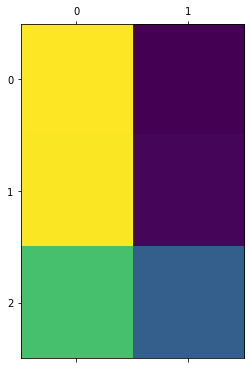

In [95]:
from sklearn.cluster import KMeans
from time import time
from sklearn import metrics
from sklearn.metrics.cluster import contingency_matrix

true_k = 2 

km = KMeans(
        n_clusters=true_k,
        init="k-means++",
        max_iter=2000,
        n_init=100)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X_train1_tfidf)
labels = y_train1
print("done in %0.3fs" % (time() - t0))
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
    % metrics.silhouette_score(X_train1_tfidf, km.labels_, sample_size=1000)
)
print("Contingency matrix:")
print(contingency_matrix(labels, km.labels_))
plt.matshow(contingency_matrix(labels, km.labels_))

Clustering sparse data with KMeans(max_iter=2000, n_clusters=2, n_init=100)
done in 1.398s

Homogeneity: 0.302
Completeness: 0.625
V-measure: 0.407
Adjusted Rand-Index: 0.307
Silhouette Coefficient: 0.005
Contingency matrix:
[[594   0]
 [595   3]
 [207 390]
 [ 60 540]]


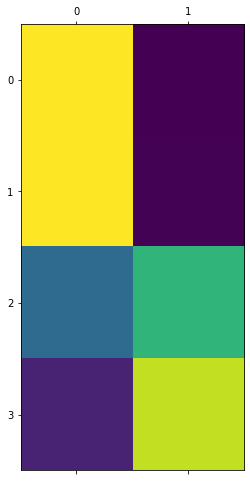

In [94]:
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X_train2_tfidf)
labels = y_train2
print("done in %0.3fs" % (time() - t0))
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(labels, km.labels_))
print(
    "Silhouette Coefficient: %0.3f"
    % metrics.silhouette_score(X_train2_tfidf, km.labels_, sample_size=1000)
)
print("Contingency matrix:")
print(contingency_matrix(labels, km.labels_))
plt.matshow(contingency_matrix(labels, km.labels_))